# Physics 760: Computational Physics
## WS 2022/23
### Week 3
#### Pugazharasu Anancia Devaneyan, Rishi Kumar Senthil Kumar

In [ ]:
#setup the notebook
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import random
import math as mth
import scipy as sp
from scipy import special

# Leapfrog Algorithm

First we define what energy difference i.e. $\Delta S$ that was defined in the lecture to be numerically.

In [2]:
def hammy(p,phi,beta,J,h,N):
    #C
    ham = ((p**2)/2) + ((phi**2)/(2*beta*J)) - (N*np.log(2*np.cosh((beta*h)+phi)))
    return ham

In [3]:
def leap(p0,phi0,J,h,beta,N,N_md):
    '''
    An implementation of the Leapfrog algorithm for the EOMs.

    :param elapsed_bake_time: int - baking time already elapsed.
    :return: int - remaining bake time (in minutes) derived from 'EXPECTED_BAKE_TIME'.

    Function that takes the actual minutes the lasagna has been in the oven as
    an argument and returns how many minutes the lasagna still needs to bake
    based on the `EXPECTED_BAKE_TIME`.
    '''
    #Setting up the initial values
    p = 0
    phi = 0
    epsilon = 1/N_md
    
    #Performing the first half step
    p = p0
    phi = phi0 + ((epsilon/2)*p0)
    
    #Iterating through the Ṇ
    for i in range(1,N_md-1):
        p = p - (epsilon*((phi/(beta*J))-(N*np.tanh((beta*h)+phi))))
        phi += epsilon*p
        
    #Performing the final leap
    p = p - (epsilon*((phi/(beta*J))-(N*np.tanh((beta*h)+phi))))
    phi += (epsilon/2)*p
    return p,phi

Now we plot

In [22]:
p_leap = 1
phi_leap = 1
J_leap = 0.5
h_leap = 0.2
beta_leap = 0.5
N_leap = 20

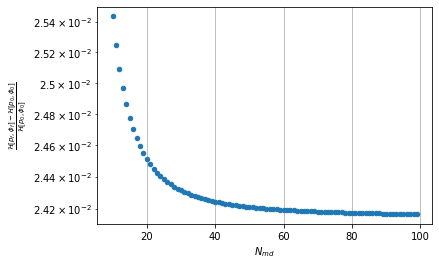

In [38]:
initial_hammy = hammy(p_leap,phi_leap,J_leap,h_leap,beta_leap,N_leap)
N_mds = np.arange(10,100)
y_axis = []

for n in N_mds:
    integ = leap(p_leap,phi_leap,beta_leap,J_leap,h_leap,N_leap,n)
    final_hammy = hammy(integ[0],integ[1],J_leap,h_leap,beta_leap,N_leap) 
    y = (final_hammy-initial_hammy)/initial_hammy
    y_axis.append(y)

plt.plot(N_mds,y_axis,marker='.',markersize=9,linestyle='')
plt.yscale('log')
plt.xlabel('$N_{md}$')
plt.ylabel('$\\frac{\\mathcal{H}\\left[p_f, \\phi_f\\right]-\\mathcal{H}\\left[p_0, \\phi_0\\right]}{\\mathcal{H}\\left[p_0, \\phi_0\\right]}$')
plt.grid()
plt.savefig('Plots/h_v_n.png',dpi=300, bbox_inches = "tight")

# Hybrid Monte Carlo algorithm

In [27]:
def distribution_function(beta,J,h,N,x):
    J_N = J/N
    fun = np.exp(0.5*(beta*J_N*(x**2))+(beta*h*x))
    return fun

In [32]:
def partition_function(beta,J,h,N):
    Z = 0
    for n in range(N):
        current = N-(2*n)
        Z += special.comb(N, n)*distribution_function(beta,J,h,N,current)
    return Z

In [34]:
def exact_energy(beta,J,h,N):
    energy = 0
    Z = partition_function(beta,J,h,N)
    for n in range(N):
        current = N-(2*n)
        energy += special.comb(N, n)*((0.5*beta*(J/N)*(current**2))+ (beta*h*current))*distribution_function(beta,J,h,N,current)
    energy = energy*(1/(N*Z))*(-1)    
    return energy

In [35]:
def exact_mag(beta,J,h,N):
    mag = 0
    Z = partition_function(beta,J,h,N)
    for n in range(N):
        current = N-(2*n)
        mag += special.comb(N, n)*current*distribution_function(beta,J,h,N,current)
    mag = mag*(1/(N*Z))        
    return mag

In [36]:
initial_phi = 0.4
initial_p = random.gauss(0,1)

In [ ]:
def accept_reject(sweeps,p,phi,beta,J,h,N,N_md,freq=10):
    phi_list = []
    phi.append(phi)
    
    init_ham = hammy()
    new_vars = []
    new_hammy = 0
    
    for i in range(sweeps):
        new_vars = leap()
        new_hammy = hammy()
        
        rand = np.random.random()
        # fill in the metropolis critereon
        if rand<min(1,np.exp(init_ham - new_hammy)) :
            phi_list.append(new_vars[])
        else:
            phi_list.append(new_vars[])
        
    return phi_list

In [24]:
def numerical_mag(beta_h,phi):
    mag = np.tanh(beta_h + phi)
    return mag

In [25]:
def numerical_energy(J,h,beta,N,phi):
    J_hat = J/N
    energy = (1/(N*beta)) - ((phi**2)/(2*(beta**2)*J)) - (h*numerical_mag((beta*h),phi))
    return energy

In [ ]:
h_input = np.linspace(-1,1,100)
h_fixed = 0.5
N_fixed = 20
N_input = [2,3,4,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
Temp_set = 0.75
J_fixed = 1
sweeps = N_fixed*100
beta = 1/Temp_set

In [ ]:
m_thermo_1 = []
m_exact_1 = []
for i in h_input:
    m_thermo_1.append(thermo_magnetization(J_fixed,float(i),Temp_set))
    m_exact_1.append(exact_magnetization(J_fixed,i,Temp_set,N_fixed)/100)

In [ ]:
m_vs_h = []
for h in h_input:
    m_h = accept_reject(sweeps, N_fixed, beta, J_fixed,h)
    mean_m = np.mean(m_h[len(m_h)//2:])
    m_vs_h.append(mean_m)


plt.plot(h_input,m_vs_h,marker='o',label="Simulation",linestyle='')
plt.plot(h_input, m_thermo_1, color ='#fbbb00', label='Solution in the Thermodynamic Limit')
plt.plot(h_input, m_exact_1, color = '#949387', label='Exact solution')

plt.xlabel('$h$')
plt.ylabel('$\\langle m \\rangle$')
plt.legend(loc='lower right',prop={'size': 7})
plt.savefig('m_v_h.png')